# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and submit it **and a `.txt` file** (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename1=07_Assignment_3.ipynb
local_scp_filepath1=~/git/iaml2017/${filename1}
filename2=assignment_3_predictions.txt
local_scp_filepath2=~/git/iaml2017/${filename2}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
scp -r ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
# rsync -rl ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
# rsync -rl ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Include all required imports and execute the cell below. It's typical to include package imports at the top of the file for clarity.

In [187]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.dummy import DummyClassifier
%matplotlib inline

# Your code goes here

## Description of the dataset
In this assignment our goal is to recognize objects in images of realistic scenes. There are 19 different classes of object e.g. person, dog, cat, car, etc. The dataset derives from several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

We are going to detect whether images contain a person or not - a binary classification problem. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. Each column of the dataset (which is not an lable), refers to a 'visual word'. Each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 different visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). See the Appendix at the bottom of the notebook for more information. The image data is thus a $N \times 500$ dimensional matrix where `N` is the number of images.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) are a normalized count vector for each visual word. The last 19 attributes (`is_class`) are the labels - 1 means the class is present in the image. In most of the experiments (unless explicitly noted otherwise) you will only need the `is_person` attribute and the 500 dimensional feature vector. **Do not use the additional class indicator attributes as features** unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

**Important**: *Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 --- [1 mark] ==========
Create two Pandas DataFrame objects called `train_A` and `valid_A` by loading the datasets `train_images_partA.csv` and `valid_images_partA.csv`. Display the number of data points and attributes in each of the two datasets.

In [188]:
# Your code goes here
data_path1 = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
data_path2 = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
train_A = pd.read_csv(data_path1, delimiter = ',')
valid_A = pd.read_csv(data_path2, delimiter = ',')
print('Train_A  Number of data points: {}, number of attributes: {}'.format(train_A.shape[0], train_A.shape[1]))
print('Valid_A  Number of data points: {}, number of attributes: {}'.format(valid_A.shape[0], valid_A.shape[1]))


Train_A  Number of data points: 2093, number of attributes: 520
Valid_A  Number of data points: 1113, number of attributes: 520


### ========== Question 1.2 --- [1 mark] ==========
Display and inspect the first 10 instances in the training dataset.

In [189]:
# Your code goes here
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 --- [1 mark] ==========
Select the attributes (i.e. input features) for training our classifiers. These should be the visual word normalised counts `dim1, dim2, ..., dim500`. Create a list of the **names** of the attributes of interest. 

In [190]:
# Your code goes here
tr_name=[]
val_name=[]
for col in train_A.columns[1:501]:
    tr_name.append(col)
for col in valid_A.columns[1:501]:
    val_name.append(col)

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` in which to store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets. Display the dimensionalities (i.e shapes) of the 4 arrays. 

Check this carefully - you will be penalised in following questions if the data is not correct!

In [191]:
# Your code goes here
X_tr = train_A[tr_name]
y_tr = train_A['is_person']
X_val = valid_A[val_name]
y_val = valid_A['is_person']

print('dimensionalities of instances in X_train: {}'.format(X_tr.shape))
print('dimensionalities of instances in X_valid: {}'.format(X_val.shape))

print('dimensionalities of instances in y_train: {}'.format(y_tr.shape))
print('dimensionalities of instances in y_valid: {}'.format(y_val.shape))


dimensionalities of instances in X_train: (2093, 500)
dimensionalities of instances in X_valid: (1113, 500)
dimensionalities of instances in y_train: (2093,)
dimensionalities of instances in y_valid: (1113,)


### ========== Question 1.5 --- [2 marks] ==========
Create a [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) for the training and validation targets. Create a single figure, and put the two plots inside the single figure. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

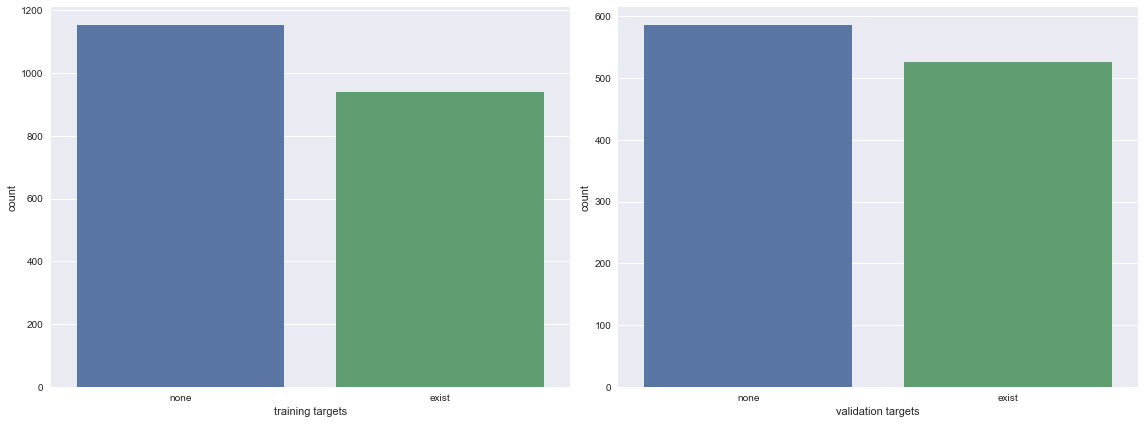

In [192]:
# Your code goes here
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(16,6))
sns.countplot(y_tr, ax=ax1)
sns.countplot(y_val, ax=ax2)
    #ax1.set_xticklabels('no_p)
labels=['none','exist']
ax1.set_xticklabels(labels)
ax2.set_xticklabels(labels)
ax1.set_xlabel('training targets')
ax2.set_xlabel('validation targets')
plt.tight_layout()
plt.show()

### ========== Question 1.6 --- [1 mark] ==========
We want to make a baseline classification accuracy to beat. Pick a baseline "dummy" classifier, describe in a sentence why you chose it, and report the accuracy it achieves on the validation set?

*Your answer goes here*
Assuming that all points were labelled as 0 in "is_person" is the simplest classification way.

In [193]:
# Your code goes here
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_tr,y_tr )

print('The baseline classifier (most frequent) would achieve a classification accuracy score of: {:.3f}'.
      format(dummy_classifier.score(X_val,y_val)))


The baseline classifier (most frequent) would achieve a classification accuracy score of: 0.527


### ========== Question 1.7 --- [3 marks] ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score on the training and validation sets and compare with the baseline. Comment on the results with 1-2 sentences. You may include any additional plot(s) if you wish to justify your explanation.

In [194]:
# Your code goes here
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr)
lr.fit(X_val, y_val)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(X_tr, y_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(lr.score(X_val, y_val)))


Classification accuracy on training set: 0.551
Classification accuracy on validation set: 0.527


*Your answer goes here*
The classifier the classifier generalises not well. Although the classification accuracy on the test set is comparable to the training classification, the result is not much better than the 'dummy' baseline.

### ========== Question 1.8 --- [1 mark] ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [195]:
# Your code goes here
tr_name2=[]
for col in X_tr.columns[1:6]:
    tr_name2.append(col)
    for i in tr_name2:
        me=np.mean(X_tr[i])
        var=np.var(X_tr[i])
    print("Feature {}: The mean is {:.7f} and standard deviation is {:.7f}".format(i,me,var))   

Feature dim2: The mean is 0.0007559 and standard deviation is 0.0000020
Feature dim3: The mean is 0.0043169 and standard deviation is 0.0000136
Feature dim4: The mean is 0.0018528 and standard deviation is 0.0000018
Feature dim5: The mean is 0.0022725 and standard deviation is 0.0000026
Feature dim6: The mean is 0.0022204 and standard deviation is 0.0000030


### ========== Question 1.9 --- [3 marks] ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers a [class](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) for feature standardisation. Instansiate a StandardScaler object and fit it using the **training features**. Use this fitted object to transform both your training and validation features to have a standard scale. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. Why didn't we use the validation set to standardise the data?

**IMPORTANT: You should use the transformed data for the rest of this part.**

In [196]:
# Your code goes here
X=StandardScaler().fit(X_tr)
X_ttr = X.transform(X_tr)
X_ttr = pd.DataFrame(X_ttr)
X_tval = X.transform(X_val)
X_tval = pd.DataFrame(X_tval)
ttr_name=[]
tval_name=[]
for colt in (X_ttr.columns[1:6]):
    ttr_name.append(colt)
    for i in (ttr_name):
        met=np.mean(X_ttr[i])
        vart=np.var(X_ttr[i])
    print("Train_Feature {}: The mean is {:.3f} and standard deviation is {:.3f}".format(i,met,vart))   
for colv in (X_tval.columns[1:6]):
    tval_name.append(colv)
    for r in (tval_name):
        mev=np.mean(X_tval[r])
        varv=np.var(X_tval[r])
    print("Valid_Feature {}: The mean is {:.3f} and standard deviation is {:.3f}".format(r,mev,varv))   


Train_Feature 1: The mean is 0.000 and standard deviation is 1.000
Train_Feature 2: The mean is 0.000 and standard deviation is 1.000
Train_Feature 3: The mean is 0.000 and standard deviation is 1.000
Train_Feature 4: The mean is -0.000 and standard deviation is 1.000
Train_Feature 5: The mean is 0.000 and standard deviation is 1.000
Valid_Feature 1: The mean is -0.038 and standard deviation is 0.941
Valid_Feature 2: The mean is 0.109 and standard deviation is 1.101
Valid_Feature 3: The mean is 0.094 and standard deviation is 1.117
Valid_Feature 4: The mean is 0.031 and standard deviation is 0.950
Valid_Feature 5: The mean is -0.063 and standard deviation is 0.802


*Your answer goes here*
The means and standard deviations of training features all have a standard scale, respectively 0 and 1. But the means of validation features are not 0 and standard deviations are not 1, that mainly because the StandardScaler model was fit by the trainging features. 

### ========== Question 1.10 --- [3 marks] ==========
By using the transformed input data, train a new `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy on both the training and validation sets.

Comment on how your model compares to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [197]:
# Your code goes here
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_ttr, y_tr)
#lr.fit(X_tval, y_val)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(X_ttr, y_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(lr.score(X_tval, y_val)))

Classification accuracy on training set: 0.811
Classification accuracy on validation set: 0.643


*Your answer goes here*
LogisticRegression classifier generalise much better on unseen data than training data after the data been transformed. But the accuracy of training sets is not much better than baseline.


### ========== Question 1.11 --- [1 mark] ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes in the weight vector. This can help us prevent overfitting but, if set too high, could lead us to underfit too.

Create a 3-fold cross-validation object. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples for each fold.

In [198]:
# Your code goes here 
kf = KFold(n_splits=3, random_state=0, shuffle=True)
X_ttr=np.asarray(X_ttr)
for k, (train_index, test_index) in enumerate(kf.split(X_ttr,y_tr)):
    print("TEST:", test_index.shape)        
    X_train, X_test = X_ttr[train_index], X_ttr[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index] 
    

TEST: (698,)
TEST: (698,)
TEST: (697,)



### ========== Question 1.12 --- [2 marks] ========== 
Using the cross-validation iterator from the previous question, perform a search for the best value for `C`. 

We are going to loop over each CV fold, and each value of `C`. The values of `C` to search should be 20 equally-spaced values **in log space** ranging from `1e-5` to `1e5` *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters (except for `C` obviously!).

*(hint: you could use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [199]:
# Your code goes here
C = np.logspace(-5, 5, 20)
acc_array= np.zeros((3,20))
i=0
for k, (train_index, test_index) in enumerate(kf.split(X_ttr,y_tr)):
    j=0
    for c_value in C:
        lr = LogisticRegression(solver='lbfgs', C=c_value)
        lr.fit(X_ttr[train_index], y_tr[train_index])
        acc = lr.score(X_ttr[test_index], y_tr[test_index])
        #print("{} {} :{}".format(k,i,acc))
        acc_array[i,j]=acc
        j+=1
    i+=1
acc_array
       #array[k][j].append(acc1[:20])
#print(np.shape(acc1))

array([[ 0.5730659 ,  0.62893983,  0.66762178,  0.67191977,  0.68767908,
         0.69627507,  0.6747851 ,  0.67048711,  0.65329513,  0.65902579,
         0.65902579,  0.65329513,  0.64899713,  0.64613181,  0.64613181,
         0.64899713,  0.64613181,  0.64613181,  0.64899713,  0.64899713],
       [ 0.54584527,  0.63180516,  0.69484241,  0.71919771,  0.72922636,
         0.73495702,  0.70200573,  0.6747851 ,  0.65472779,  0.63610315,
         0.63180516,  0.63323782,  0.6260745 ,  0.62750716,  0.62750716,
         0.6260745 ,  0.6260745 ,  0.6260745 ,  0.62750716,  0.6260745 ],
       [ 0.54806313,  0.63558106,  0.64275466,  0.65566714,  0.68005739,
         0.70014347,  0.68149211,  0.67001435,  0.66284075,  0.64418938,
         0.63271162,  0.62553802,  0.6241033 ,  0.6241033 ,  0.6241033 ,
         0.6241033 ,  0.6241033 ,  0.6241033 ,  0.6241033 ,  0.6241033 ]])


### ========== Question 1.13 --- [1 mark] ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

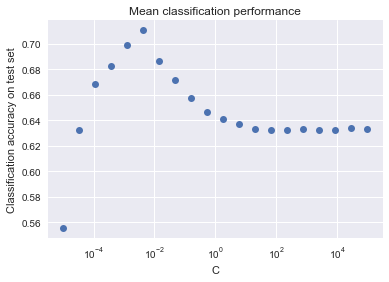

the max accuracy is:0.710458521238 when c = 0.00428133239872


In [200]:
# Your code goes here
acc_mean=acc_array.mean(axis=0)
plt.plot(C,acc_mean,'o')
plt.xlabel('C')
plt.xscale("log")
plt.ylabel('Classification accuracy on test set')
plt.title('Mean classification performance')
plt.show()
print("the max accuracy is:{} when c = {}".format(np.max(acc_mean),C[np.argmax(acc_mean)]))

### ========== Question 1.14 --- [2 marks] ==========
Display the optimal value for the regularisation parameter `C` determined by the search results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [174]:
# Your code goes here
X_tval = np.asarray(X_tval)
accv_array= np.zeros((3,20))
i=0
for k, (train_index, test_index) in enumerate(kf.split(X_tval,y_val)):
    j=0
    for c_value in C:
        lr = LogisticRegression(solver='lbfgs', C=C[np.argmax(acc_mean)])
        lr.fit(X_tval[train_index], y_val[train_index])
        acc = lr.score(X_tval[test_index], y_val[test_index])
        #print("{} {} :{}".format(k,i,acc))
        accv_array[i,j]=acc
        j+=1
    i+=1
accv_mean=accv_array.mean(axis=0)
np.argmax(accv_mean)
print("the max accuracy is:{} when c = {}".format(np.max(accv_mean),C[np.argmax(accv_mean)]))

the max accuracy is:0.684636118598 when c = 0.00428133239872


### ========== Question 1.15 --- [1 mark] ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Check your results are consistent with those from Question 1.14!

In [185]:
# Your code goes here
X_tval = np.asarray(X_tval)
acc_lrc= np.zeros((3,20))
i=0
for k, (train_index, test_index) in enumerate(kf.split(X_tval,y_val)):
    j=0
    for c_value in C:
        lrc = LogisticRegressionCV(solver='lbfgs', Cs=C.tolist())
        lrc.fit(X_tval[train_index], y_val[train_index])
        acc = lrc.score(X_tval[test_index], y_val[test_index])
        #print("{} {} :{}".format(k,i,acc))
        acc_lrc[i,j]=acc
        j+=1
    i+=1
lrc_mean=acc_lrc.mean(axis=0)

print("the max accuracy is:{} when c = {}".format(np.max(lrc_mean),lrc.C_))


the max accuracy is:0.681042228212 when c = [ 0.01]


### ========== Question 1.16 --- [1 mark] ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 42 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [177]:
# Your code goes here
clf = RandomForestClassifier(random_state=42,n_estimators=500)
clf.fit(X_ttr, y_tr)
acc_val = clf.score(X_tval,y_val)
acc_tr = clf.score(X_ttr,y_tr)
print('The accuracy score on the training sets:{} '.format(acc_tr))
print('The accuracy score on the validation sets:{}'.format(acc_val))

The accuracy score on the training sets:1.0 
The accuracy score on the validation sets:0.692722371968


### ========== Question 1.17 --- [2 marks] ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

*Your answer goes here*
The model was fitted with the training data, so the acccuracy result on training data set is high, but much lower on validation datasets.

### ========== Question 1.18 --- [2 marks] ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

['dim21', 'dim51', 'dim360', 'dim4', 'dim479', 'dim76', 'dim283', 'dim461', 'dim343', 'dim398', 'dim348', 'dim74', 'dim485', 'dim356', 'dim330', 'dim217', 'dim263', 'dim222', 'dim134', 'dim500', 'dim274', 'dim254', 'dim206', 'dim423', 'dim347', 'dim17', 'dim326', 'dim90', 'dim92', 'dim329', 'dim214', 'dim322', 'dim289', 'dim54', 'dim440', 'dim427', 'dim73', 'dim35', 'dim77', 'dim312', 'dim315', 'dim96', 'dim288', 'dim483', 'dim299', 'dim48', 'dim442', 'dim201', 'dim344', 'dim294']


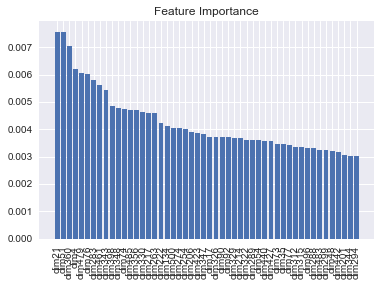

In [178]:
# Your code goes here
#for feature in zip(tr_name, clf.feature_importances_):
    #print(feature)
importances = clf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
X_ttr=pd.DataFrame(X_ttr)
# Rearrange feature names so they match the sorted feature importances
names = [tr_name[i] for i in indices]
print(names[0:50])
# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X_ttr.shape[1])[0:50], importances[indices[0:50]])
# Add feature names as x-axis labels
plt.xticks(range(X_ttr.shape[1])[0:50], names[0:50], rotation=90)
# Show plot
plt.show()


### ========== Question 1.19 --- [3 marks] ==========
Next, we would like to test the performance of support vector machines. Train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [179]:
# Your code goes here
svc_linear = LinearSVC()
svc_linear.fit(X_ttr, y_tr)

svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_ttr, y_tr)

svc_poly = SVC(kernel='poly')
svc_poly.fit(X_ttr, y_tr)
print('Linear SVC classification accuracy on training set: {:.3f}'.format(svc_linear.score(X_ttr, y_tr)))
print('Linear SVC classification accuracy on validation set: {:.3f}'.format(svc_linear.score(X_tval, y_val)))

print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(X_ttr, y_tr)))
print('RBF SVC classification accuracy on validation set: {:.3f}'.format(svc_rbf.score(X_tval, y_val)))

print('Poly SVC classification accuracy on training set: {:.3f}'.format(svc_poly.score(X_ttr, y_tr)))
print('Poly SVC classification accuracy on validation set: {:.3f}'.format(svc_poly.score(X_tval, y_val)))



Linear SVC classification accuracy on training set: 0.811
Linear SVC classification accuracy on validation set: 0.642
RBF SVC classification accuracy on training set: 0.911
RBF SVC classification accuracy on validation set: 0.730
Poly SVC classification accuracy on training set: 0.991
Poly SVC classification accuracy on validation set: 0.702


### ========== Question 1.20 --- [3 marks] ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the shape of the boundaries and what this means for classification accuracy in 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [180]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    Titles = ['rbf_svc','poly_svc','lin_svc']
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(40,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])
            

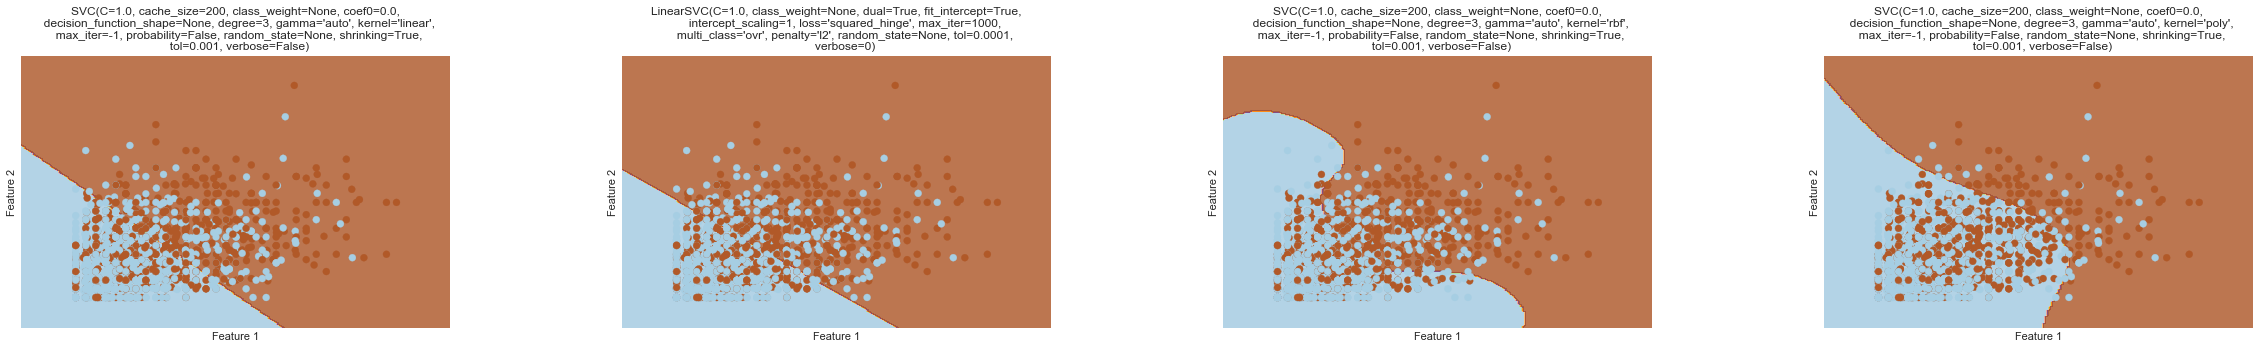

In [181]:
# Your code goes here
X = pd.DataFrame()
X[1] = X_ttr[20]
X[2] = X_ttr[75]
X = np.asarray(X)
svc = svm.SVC(kernel='linear').fit(X, y_tr)
rbf_svc = svm.SVC(kernel='rbf').fit(X,y_tr)
poly_svc = svm.SVC(kernel='poly').fit(X,y_tr)
lin_svc = svm.LinearSVC().fit(X,y_tr)
clfs =[svc,lin_svc,rbf_svc,poly_svc]
show_svc_decision_boundaries(clfs, X, title=clfs)

*Your answer goes here*
Both of the linear models has linear decision boundaries (intersecting hyperplanes) while the non-linear kernel models (polynomial or Gaussian RBF) have more flexible non-linear decision boundaries with shapes that depend on the kind of kernel and its parameters.

### ========== Question 1.21 --- [5 marks] ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [184]:
# Your code goes here
C = np.logspace(-2, 3, 10)
X_ttr = np.asarray(X_ttr)
acc_svm= np.zeros((3,10))
i=0
for k, (train_index, test_index) in enumerate(kf.split(X_ttr,y_tr)):
    j=0
    for c_value in C:
        rbf_svc = svm.SVC(kernel='rbf', gamma='auto', C=c_value)
        rbf_svc.fit(X_ttr[train_index], y_tr[train_index])
        acc = rbf_svc.score(X_ttr[test_index], y_tr[test_index])
        acc_svm[i,j]=acc
        j+=1
    i+=1
svm_mean=acc_svm.mean(axis=0)
print("the max accuracy is:{} when c = {}".format(np.max(svm_mean),C[np.argmax(svm_mean)]))
rbf_svc = svm.SVC(kernel='rbf', gamma='auto', C=C[np.argmax(svm_mean)])
rbf_svc.fit(X_ttr, y_tr)
acc_scor1 = rbf_svc.score(X_ttr, y_tr)
acc_scor2 = rbf_svc.score(X_tval, y_val)
print('Classification accuracy on the training sets:{}'.format(acc_scor1))
print('Classification accuracy on the validation sets:{}'.format(acc_scor2))


the max accuracy is:0.715230644637 when c = 1.6681005372
Classification accuracy on the training sets:0.974677496417
Classification accuracy on the validation sets:0.727762803235


### ========== Question 1.22 --- [5 marks] ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [ ]:
# Your code goes here
gamma = np.logspace(-5, 0, 10)
C = 1.0
acc4 = []
X_ttr = np.asarray(X_ttr)
for k, (train, test) in enumerate(kf.split(X_ttr,y_tr)):
    for i in gamma:
            rbf_svc = svm.SVC(kernel='rbf', gamma=i, C=C)
            rbf_svc.fit(X_ttr[train], y_tr[train])
            acc = rbf_svc.score(X_ttr[test], y_tr[test])
            acc4.append(acc)    
slice1 = acc4[0:10]
slice2 = acc4[10:20]
slice3 = acc4[20:30]
plt.scatter(gamma, slice1)
plt.scatter(gamma, slice2)
plt.scatter(gamma, slice3)
plt.xlabel('gamma')
plt.ylabel('Classification accuracy on test set')
plt.title('Mean classification performance')
plt.show()
# View the best parameters for the model found using grid search
gamma=[{'gamma':np.logspace(-5, 0, 10)}]
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=rbf_svc, param_grid=gamma, n_jobs=-1)
# Train the classifier on data1's feature and target data
clf.fit(X_ttr, y_tr) 
print('Best C:',clf.best_estimator_.gamma) 
# View the accuracy score
print('Best score for test data:', clf.best_score_) 
rbf_svc = svm.SVC(kernel='rbf', gamma=clf.best_estimator_.gamma, C=C)
rbf_svc.fit(X_ttr, y_tr)
acc_scor3 = rbf_svc.score(X_ttr, y_tr)
acc_scor4 = rbf_svc.score(X_tval, y_val)
print('Classification accuracy on the training sets:{}'.format(acc_scor3))
print('Classification accuracy on the validation sets:{}'.format(acc_scor4))


### ========== Question 1.23 --- [7 marks] ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [ ]:
# Your code goes here
C = np.logspace(-2, 1, 4)
gamma = np.logspace(-4, -1, 4)
acc5 = []
X_ttr = np.asarray(X_ttr)
for k, (train, test) in enumerate(kf.split(X_ttr,y_tr)):
    for i in gamma:
        for j in C:
            rbf_svc = svm.SVC(kernel='rbf', gamma=i, C=j)
            rbf_svc.fit(X_ttr[train], y_tr[train])
            acc = rbf_svc.score(X_ttr[test], y_tr[test])
            acc5.append(acc)
acc_s = pd.DataFrame()
acc_s[1] = acc5[0:16]
acc_s[2] = acc5[16:32]
acc_s[3] = acc5[32:48]

ax = sns.heatmap(acc_s)
param=[{'C':np.logspace(-2, 1, 4),'gamma': np.logspace(-4, -1, 4)}]
clf = GridSearchCV(estimator=rbf_svc, param_grid=param, n_jobs=-1)
# Train the classifier on data1's feature and target data
clf.fit(X_ttr, y_tr) 
print('Best gamma:',clf.best_estimator_.gamma) 
print('Best C:',clf.best_estimator_.C) 
# View the accuracy score
print('Best score for test data:', clf.best_score_) 
rbf_svc = svm.SVC(kernel='rbf', gamma=clf.best_estimator_.gamma, C=clf.best_estimator_.C)
rbf_svc.fit(X_ttr, y_tr)
acc_scor3 = rbf_svc.score(X_ttr, y_tr)
acc_scor4 = rbf_svc.score(X_tval, y_val)
print('Classification accuracy on the training sets:{}'.format(acc_scor3))
print('Classification accuracy on the validation sets:{}'.format(acc_scor4))



### ========== Question 1.24 --- [3 marks] ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

*Your answer goes here*
In fact, the acuracy result is lower than the previous questions, that shows when more than parameter should be taken into consider and reach the best performing configuration. Because  gamma is the 'spread' of the kernel and C is the Penalty Parameter therefore the decision region shold consider both the parameter.   

### ========== Question 1.25 --- [5 marks] ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [ ]:
# Your code goes here
degree = np.arange(1,8)
acc6 = []
X_ttr = np.asarray(X_ttr)
for k, (train, test) in enumerate(kf.split(X_ttr,y_tr)):
    for i in degree:
        rbf_svc = svm.SVC(kernel='poly', degree=i)
        rbf_svc.fit(X_ttr[train], y_tr[train])
        acc = rbf_svc.score(X_ttr[test], y_tr[test])
        acc6.append(acc)
slice1 = acc6[0:7]
slice2 = acc6[7:14]
slice3 = acc6[14:21]
plt.scatter(degree, slice1)
plt.scatter(degree, slice2)
plt.scatter(degree, slice3)
plt.xlabel('degree')
plt.ylabel('Classification accuracy on test set')
plt.title('Mean classification performance')
plt.show()
# View the best parameters for the model found using grid search
degree=[{'degree':np.arange(1,8)}]
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=rbf_svc, param_grid=degree, n_jobs=-1)
# Train the classifier on data1's feature and target data
clf.fit(X_ttr, y_tr) 
print('Best degree:',clf.best_estimator_.degree) 
# View the accuracy score
print('Best score for test data:', clf.best_score_) 
rbf_svc = svm.SVC(kernel='rbf', gamma=clf.best_estimator_.degree)
rbf_svc.fit(X_ttr, y_tr)
acc_scor3 = rbf_svc.score(X_ttr, y_tr)
acc_scor4 = rbf_svc.score(X_tval, y_val)
print('Classification accuracy on the training sets:{}'.format(acc_scor3))
print('Classification accuracy on the validation sets:{}'.format(acc_scor4))



### ========== Question 1.26 --- [4 marks] ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

*Your answer goes here*
The hold out validation only split the datasets once so it is a fast split way. But the result is not accuracy enough for the problem, because we want to evaluste the influence of diiferent prameters not by one part of training sets and validation sets. Cross-validation will spilt the traing and test sets many times which means we can evaluate the result based on more data and that is more accuracy, but it is really time consuming when run the prosedure.

### ========== Question 1.27 --- [6 marks] ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [ ]:
# Your code goes here
data_path1 = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
data_path2 = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
train_A1 = pd.read_csv(data_path1, delimiter = ',')
valid_A1 = pd.read_csv(data_path2, delimiter = ',')
train_A1 = train_A1.drop('imgId',axis=1)
valid_A1 = valid_A1.drop('imgId',axis=1)
tr_A1 = train_A1.drop('is_person',axis=1)
val_A1 = valid_A1.drop('is_person',axis=1)
y_train = train_A1['is_person']
y_validation = valid_A1['is_person']
T=StandardScaler().fit(tr_A1)
V=StandardScaler().fit(val_A1)
T_tr = T.transform(tr_A1)
T_tr = pd.DataFrame(T_tr)
V_tr = V.transform(val_A1)
V_tr = pd.DataFrame(V_tr)
clf1 = RandomForestClassifier(random_state=31,criterion='entropy',n_estimators=500)
clf1.fit(T_tr, y_train)
acc_tr1 = clf1.score(T_tr, y_train)
acc_val1 = clf1.score(V_tr, y_validation)
print('The accuracy score on the training sets:{} '.format(acc_tr1))
print('The accuracy score on the validation sets:{}'.format(acc_val1))

In [ ]:
#for feature in zip(tr_name, clf.feature_importances_):
    #print(feature)
importances = clf1.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [tr_A1.columns[i] for i in indices]
print(names[0:50])
# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(tr_A1.shape[1])[0:50], importances[indices[0:50]])
# Add feature names as x-axis labels
plt.xticks(range(tr_A1.shape[1])[0:50], names[0:50], rotation=90)
# Show plot
plt.show()

*Your answer goes here*
This time the first features contain 'is_cat' and 'is_bird'not only visual word normalised counts dim1, dim2, ..., dim500. And the classification accuracy improved when compared with 1.16. That indicates when some attributes' importance is hign, it can inflence the final accuracy of classification.

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classifier you like (with the provison that you can explain what the classifier is/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated probabilities for the data points in the test set in a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. Submit this file along with your notebook as detailed at the top of this file.

*Your answer goes here (max. 600 words)*



In [ ]:
# Your code goes here
data_path1 = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
data_path2 = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
data_path3 = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
train_B = pd.read_csv(data_path1, delimiter = ',')
valid_B = pd.read_csv(data_path2, delimiter = ',')
test_B = pd.read_csv(data_path3, delimiter = ',')
trB_name=[]
valB_name=[]
for col in train_B.columns[1:501]:
    trB_name.append(col)
for col in valid_B.columns[1:501]:
    valB_name.append(col)
tr_B = train_B[trB_name]
val_B = valid_B[valB_name]
test_B = test_B.drop('is_person',axis=1)
y_trB = train_B['is_person']
y_valB = valid_B['is_person']
T=StandardScaler().fit(tr_B)
V=StandardScaler().fit(val_B)
Test=StandardScaler().fit(test_B)
T_tr = T.transform(tr_B)
T_tr = pd.DataFrame(T_tr)
V_tr = V.transform(val_B)
V_tr = pd.DataFrame(V_tr)
Test = Test.transform(test_B)
Test = pd.DataFrame(Test)
svc = svm.SVC(kernel='linear',probability=True).fit(T_tr, y_trB)
rbf_svc = svm.SVC(kernel='rbf',probability=True).fit(T_tr, y_trB)
poly_svc = svm.SVC(kernel='poly',probability=True).fit(T_tr, y_trB)
rfc = RandomForestClassifier(random_state=31,criterion='entropy',n_estimators=500)
rfc.fit(T_tr, y_trB)
lrc = LogisticRegressionCV(solver='lbfgs',cv=kf)
lrc.fit(T_tr, y_trB)
lr = LogisticRegression(solver='lbfgs')
lr.fit(T_tr, y_trB)
clfs =[svc,rbf_svc,poly_svc,rfc,lrc,lr]

for i, clf in enumerate(clfs):
    y_pred = clf.predict_proba(V_tr)
    loss =  log_loss(y_valB, y_pred)
    print('The loss of the{}:{}'.format(i,loss))

According to the result of logarithmic loss, after fitting the model with training dataset and evaluate the log_loss based on predict_proba of validation datasets I chose SVC(kernel='linear') as the classification model and apply it to the test sets.

In [ ]:
# View the best parameters for the model found using grid search
prameter=[{'degree':np.arange(1,5)},{'C':np.logspace(-2, 1, 4)},{'gamma': np.logspace(-4, -1, 4)}]
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=svc, param_grid=prameter, n_jobs=-1)
# Train the classifier on data1's feature and target data
clf.fit(T_tr, y_trB) 
print('Best degree:',clf.best_estimator_.degree)
print('Best C:',clf.best_estimator_.C) 
print('Best gamma:',clf.best_estimator_.gamma) 
# View the accuracy score
svc = svm.SVC(kernel='linear', gamma=clf.best_estimator_.gamma,
              C=clf.best_estimator_.C,degree=clf.best_estimator_.degree,probability=True)
svc.fit(T_tr, y_trB)
acc_scor7 = svc.score(T_tr, y_trB)
acc_scor8 = svc.score(V_tr, y_valB)
print('Classification accuracy on the training sets:{}'.format(acc_scor7))
print('Classification accuracy on the validation sets:{}'.format(acc_scor8))

After choosing the model, then use the GridSearchCV to decide the best pramaters for the model and show the accuracy score of tarin and validation dataset. Then use the model on the test datasets. 

In [ ]:
testB_proba = svc.predict_proba(Test)
testB_proba

In [ ]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array is not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

# You need to replace "test_images_partB_pred_proba"
# with the name of the array which contains the probability 
# estimates for the data in the test set.
save_predictions(testB_proba) 

# Appendix

## More information about visual words

Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image)